<a href="https://colab.research.google.com/github/annesofiedahl/customer_churn_prediction/blob/main/Copy_of_Copy_of_Copy_of_Project_The_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np 
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
import collections
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter
from keras.callbacks import EarlyStopping
import plotly.express as px

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing the train and test set
data = pd.read_csv('../content/drive/MyDrive/Data/train_v2.csv')

In [ ]:
data

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1
...,...,...
970955,OHnZbu+EVaP+vN7Z+OfT5OMcp90MWFZonmM0o3pb8FY=,0
970956,S92bDK//uI6hk3u1vuApro0qJBQOToBozZ7lL1yTC+w=,0
970957,eUa3xo16vpAjr43Cjlb6Kjf1NTILYyJIkBayJQdXWnw=,0
970958,iZE41tbAQ65rJq60olkJT4BJzuUAYgQdfbEemXe/TTk=,0


In [ ]:
#importing and concatenating the transactions datasets
#creating a value_count on the transactions data for each user
#merging the train and test datasets with the transactions trans_count from the transactions dataset
transactions = pd.read_csv('../content/drive/MyDrive/Data/transactions_v2.csv', usecols=['msno'])
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','trans_count']
data = pd.merge(data, transactions, how='left', on='msno')

In [ ]:
data = data.dropna()

In [ ]:
data

,msno,is_churn,trans_count
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,1.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,2.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,10.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,8.0
5,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,1.0
...,...,...,...
970955,OHnZbu+EVaP+vN7Z+OfT5OMcp90MWFZonmM0o3pb8FY=,0,1.0
970956,S92bDK//uI6hk3u1vuApro0qJBQOToBozZ7lL1yTC+w=,0,1.0
970957,eUa3xo16vpAjr43Cjlb6Kjf1NTILYyJIkBayJQdXWnw=,0,1.0
970958,iZE41tbAQ65rJq60olkJT4BJzuUAYgQdfbEemXe/TTk=,0,2.0


In [ ]:
#importing the transactions dataset again
#sorting values by descending transaction_date 
#dropping all the duplicates of the msno column
#merging this dataset with the train and test set again
transactions = pd.read_csv('../content/drive/MyDrive/Data/transactions_v2.csv') 
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')
data = pd.merge(data, transactions, how='left', on='msno')
data

,msno,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,1.0,36,30,180,180,0,20170311,20170411,0
1,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,2.0,15,90,300,300,0,20170314,20170615,0
2,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,10.0,41,30,149,149,1,20151208,20180108,0
3,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,8.0,41,30,99,99,1,20170316,20170918,0
4,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,1.0,40,30,149,149,1,20170316,20170314,1
...,...,...,...,...,...,...,...,...,...,...,...
933573,OHnZbu+EVaP+vN7Z+OfT5OMcp90MWFZonmM0o3pb8FY=,0,1.0,40,30,149,149,1,20170304,20170403,0
933574,S92bDK//uI6hk3u1vuApro0qJBQOToBozZ7lL1yTC+w=,0,1.0,41,30,99,99,1,20170310,20170410,0
933575,eUa3xo16vpAjr43Cjlb6Kjf1NTILYyJIkBayJQdXWnw=,0,1.0,41,30,99,99,1,20170316,20170416,0
933576,iZE41tbAQ65rJq60olkJT4BJzuUAYgQdfbEemXe/TTk=,0,2.0,39,30,149,149,1,20170331,20170513,0


In [ ]:
user_logs = pd.read_csv('../content/drive/MyDrive/Data/user_logs_v2.csv', usecols=['msno'])
user_logs = pd.DataFrame(user_logs['msno'].value_counts().reset_index())
user_logs.columns = ['msno','logs_count']

In [ ]:
user_logs = user_logs[user_logs['logs_count'] == 31]
user_logs

,msno,logs_count
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,31
1,0qLiw20oFg1MBocPTyj3qu37+yWf7UGNz0zekeSpcaM=,31
2,YWa5GpzNoF6u0117DB+4HgEuBp3IuBxvN+6I/62qoVM=,31
3,m16fMSTcxvSmxE6dF6XW1n0a9EtWsSz2mz9bfRsZ58w=,31
4,OI0Vbi3v3D1GOPP/7NTaJrK8vOxSikGirFE+qE2LMYY=,31
...,...,...
84439,FbvzwqSK+OwBIujSgDBxUlfebby0WGFW5bpM4dGT/IA=,31
84440,a1Yut14p2IWwh8LSBIjEd+lWh3rcGXtYwGU2Y88gs1M=,31
84441,d9tWAGucWiY/p9ctxDGl2Euqa5J9PHaUcStAL6wQ8Cs=,31
84442,UZWpQ8fRxfMXQN56w/ByLU8GFrS8n9qTne+VTEcB6Ak=,31


In [ ]:
data = pd.merge(data, user_logs, how='inner', on='msno')
data = data.drop(labels = 'logs_count', axis = 1)
data

,msno,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,moRTKhKIDvb+C8ZHOgmaF4dXMLk0jOn65d7a8tQ2Eds=,1,1.0,38,410,1788,1788,0,20170324,20180513,0
1,TotbNxPUifAoL9diWEMXcRnBgKDStI/a/SdXcf5WhfQ=,1,1.0,38,30,149,149,0,20170308,20170408,0
2,ec8IfcFcaF5NBLMnFzyRcnAMUmgZ46kHw7P1qHEm0o0=,1,1.0,40,30,149,149,1,20170323,20170429,0
3,VCZm6WJqkwDhmConNXKrPly5XJWE26zjE7FL9tlSqww=,1,2.0,32,360,1200,1200,0,20170306,20180226,0
4,9JzSBttiM01GFi7KjlL9pQz8vQyyvga1o5SbPMMFQXU=,1,1.0,38,30,149,149,0,20170322,20170426,0
...,...,...,...,...,...,...,...,...,...,...,...
60641,gBXsjOcpcWckBi92/TPaWO7xsoam/NpdsHFnRl4mxgU=,0,2.0,39,30,149,149,1,20170331,20170524,0
60642,zwrjn34Dqr0T+WGC98DY3Sh8vbmK5+4o2BPW0Hd/Fe4=,0,1.0,41,30,149,149,1,20170324,20170424,0
60643,PsftdQEI+bQFl8FB2+O4sKM4uRZGO/UvBCDS+ZyWmvk=,0,1.0,40,30,149,149,1,20170318,20170417,0
60644,5dXGSlRH5LQVFbTUGQwfyyaFb8w/FVqfTS8N4aNEots=,0,1.0,38,30,149,149,0,20170309,20170408,0


In [ ]:
user_logs = pd.read_csv('../content/drive/MyDrive/Data/user_logs_v2.csv')
user_logs = user_logs.groupby('msno').sum().reset_index()
user_logs

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,524428230,86,11,10,5,472,530,117907.425
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,625279796,191,90,75,144,589,885,192527.892
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,564768855,43,12,15,12,485,468,115411.260
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,423576619,207,163,100,64,436,828,149896.558
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,584939157,105,24,39,35,479,230,116433.247
...,...,...,...,...,...,...,...,...,...
1103889,zzy7iqSpfcRq7R4hmKKuhI+CJRs79a6pteqEggpiNO0=,625279796,136,69,46,61,1125,513,268039.763
1103890,zzyHq6TK2+cBkeGFUHvh12Z7UxFZiSM7dOOSllSBPDw=,322725153,17,8,7,6,2116,1591,477846.789
1103891,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,403406269,33,10,12,10,219,240,60953.725
1103892,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,221873455,10,1,1,1,232,202,59525.679


In [ ]:
data = pd.merge(data, user_logs, how='inner', on='msno')
data

,msno,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,moRTKhKIDvb+C8ZHOgmaF4dXMLk0jOn65d7a8tQ2Eds=,1,1.0,38,410,1788,1788,0,20170324,20180513,0,625279796,78,20,30,16,1023,758,290831.795
1,TotbNxPUifAoL9diWEMXcRnBgKDStI/a/SdXcf5WhfQ=,1,1.0,38,30,149,149,0,20170308,20170408,0,625279796,195,52,32,27,755,954,196523.899
2,ec8IfcFcaF5NBLMnFzyRcnAMUmgZ46kHw7P1qHEm0o0=,1,1.0,40,30,149,149,1,20170323,20170429,0,625279796,349,76,46,30,739,1101,191605.192
3,VCZm6WJqkwDhmConNXKrPly5XJWE26zjE7FL9tlSqww=,1,2.0,32,360,1200,1200,0,20170306,20180226,0,625279796,1085,258,137,153,907,2032,303608.133
4,9JzSBttiM01GFi7KjlL9pQz8vQyyvga1o5SbPMMFQXU=,1,1.0,38,30,149,149,0,20170322,20170426,0,625279796,595,120,79,99,1227,1574,335510.741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60641,gBXsjOcpcWckBi92/TPaWO7xsoam/NpdsHFnRl4mxgU=,0,2.0,39,30,149,149,1,20170331,20170524,0,625279796,70,18,9,8,967,944,243090.571
60642,zwrjn34Dqr0T+WGC98DY3Sh8vbmK5+4o2BPW0Hd/Fe4=,0,1.0,41,30,149,149,1,20170324,20170424,0,625279796,197,16,19,12,424,625,117230.317
60643,PsftdQEI+bQFl8FB2+O4sKM4uRZGO/UvBCDS+ZyWmvk=,0,1.0,40,30,149,149,1,20170318,20170417,0,625279796,157,44,45,35,1513,1355,419195.794
60644,5dXGSlRH5LQVFbTUGQwfyyaFb8w/FVqfTS8N4aNEots=,0,1.0,38,30,149,149,0,20170309,20170408,0,625279796,331,160,154,160,1239,866,355162.288


In [ ]:
data = data.drop(columns = ['date'], axis = 1)

In [ ]:
#merging the members dataset with the train and test set
members = pd.read_csv('../content/drive/MyDrive/Data/members_v3.csv')
data = pd.merge(data, members, how='inner', on='msno')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60645 entries, 0 to 60644
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msno                    60645 non-null  object 
 1   is_churn                60645 non-null  int64  
 2   trans_count             60645 non-null  float64
 3   payment_method_id       60645 non-null  int64  
 4   payment_plan_days       60645 non-null  int64  
 5   plan_list_price         60645 non-null  int64  
 6   actual_amount_paid      60645 non-null  int64  
 7   is_auto_renew           60645 non-null  int64  
 8   transaction_date        60645 non-null  int64  
 9   membership_expire_date  60645 non-null  int64  
 10  is_cancel               60645 non-null  int64  
 11  num_25                  60645 non-null  int64  
 12  num_50                  60645 non-null  int64  
 13  num_75                  60645 non-null  int64  
 14  num_985                 60645 non-null

In [ ]:
data = data.dropna()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34896 entries, 0 to 60644
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msno                    34896 non-null  object 
 1   is_churn                34896 non-null  int64  
 2   trans_count             34896 non-null  float64
 3   payment_method_id       34896 non-null  int64  
 4   payment_plan_days       34896 non-null  int64  
 5   plan_list_price         34896 non-null  int64  
 6   actual_amount_paid      34896 non-null  int64  
 7   is_auto_renew           34896 non-null  int64  
 8   transaction_date        34896 non-null  int64  
 9   membership_expire_date  34896 non-null  int64  
 10  is_cancel               34896 non-null  int64  
 11  num_25                  34896 non-null  int64  
 12  num_50                  34896 non-null  int64  
 13  num_75                  34896 non-null  int64  
 14  num_985                 34896 non-null

In [ ]:
data['transaction_date']=pd.to_datetime(data['transaction_date'],format='%Y%m%d') 
data['membership_expire_date']=pd.to_datetime(data['membership_expire_date'],format='%Y%m%d')
data['registration_init_time']=pd.to_datetime(data['registration_init_time'],format='%Y%m%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34896 entries, 0 to 60644
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    34896 non-null  object        
 1   is_churn                34896 non-null  int64         
 2   trans_count             34896 non-null  float64       
 3   payment_method_id       34896 non-null  int64         
 4   payment_plan_days       34896 non-null  int64         
 5   plan_list_price         34896 non-null  int64         
 6   actual_amount_paid      34896 non-null  int64         
 7   is_auto_renew           34896 non-null  int64         
 8   transaction_date        34896 non-null  datetime64[ns]
 9   membership_expire_date  34896 non-null  datetime64[ns]
 10  is_cancel               34896 non-null  int64         
 11  num_25                  34896 non-null  int64         
 12  num_50                  34896 non-null  int64 

In [ ]:
data = data.drop(columns = ['msno'], axis = 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34896 entries, 0 to 60644
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   is_churn                34896 non-null  int64         
 1   trans_count             34896 non-null  float64       
 2   payment_method_id       34896 non-null  int64         
 3   payment_plan_days       34896 non-null  int64         
 4   plan_list_price         34896 non-null  int64         
 5   actual_amount_paid      34896 non-null  int64         
 6   is_auto_renew           34896 non-null  int64         
 7   transaction_date        34896 non-null  datetime64[ns]
 8   membership_expire_date  34896 non-null  datetime64[ns]
 9   is_cancel               34896 non-null  int64         
 10  num_25                  34896 non-null  int64         
 11  num_50                  34896 non-null  int64         
 12  num_75                  34896 non-null  int64 

# **Data Exploration**

In [ ]:
#defining function for correlation matrix
import seaborn as sns
def corr_analysis(df = None, corr_method = 'pearson', show_graph = False):
    assert(not df.empty)
    # compute correlation
    df_corr = df.corr(method = corr_method)
    print(df_corr['is_churn'])
    # show heatmap graph
    if show_graph:
        plt.figure(figsize = (16,14))
        mask = np.zeros_like(df_corr)
        mask[np.triu_indices_from(mask)] = True
        with sns.axes_style("white"):
            #matplotlib.rcParams.update({"font.size": 8})
            sns.set(font_scale=1.2)
            sns.set(style='white')
            sns.heatmap(df_corr, cmap = "Greys", annot = False, mask = mask)
            plt.yticks(rotation=0) 
            plt.xticks(rotation=90) 
            plt.title('Correlation Analysis Between Features')

is_churn              1.000000
trans_count           0.076243
payment_method_id    -0.210752
payment_plan_days     0.586520
plan_list_price       0.568482
actual_amount_paid    0.566413
is_auto_renew        -0.397149
is_cancel             0.117572
num_25                0.014337
num_50                0.013992
num_75                0.009970
num_985              -0.001605
num_100              -0.012940
num_unq               0.007452
total_secs           -0.012746
city                 -0.005041
bd                   -0.021789
registered_via       -0.061883
Name: is_churn, dtype: float64


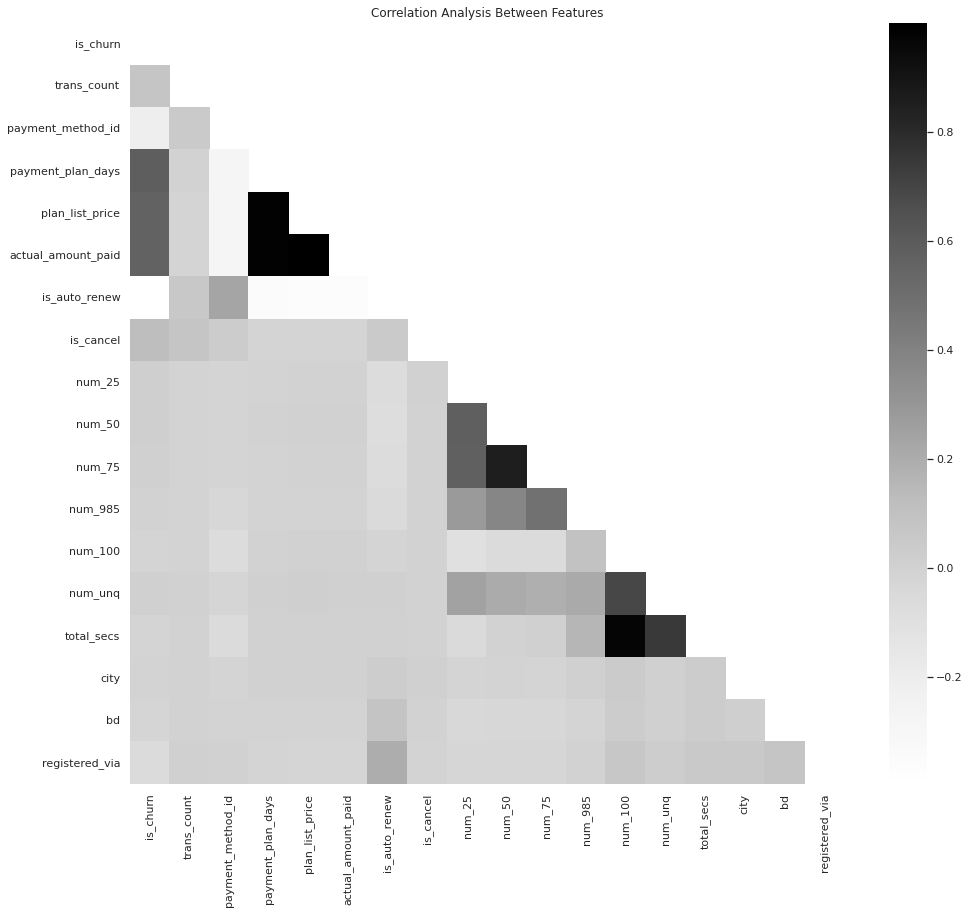

In [ ]:
# getting information regarding the correlations
corr_analysis(df = data, corr_method = 'pearson', show_graph = True)

Train

In [ ]:
data

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,gender,registered_via,registration_init_time
0,1,1.0,38,410,1788,1788,0,2017-03-24,2018-05-13,0,78,20,30,16,1023,758,290831.795,9,28,female,3,2014-02-02
1,1,1.0,38,30,149,149,0,2017-03-08,2017-04-08,0,195,52,32,27,755,954,196523.899,4,17,female,3,2014-08-12
2,1,1.0,40,30,149,149,1,2017-03-23,2017-04-29,0,349,76,46,30,739,1101,191605.192,13,24,female,3,2014-09-20
3,1,2.0,32,360,1200,1200,0,2017-03-06,2018-02-26,0,1085,258,137,153,907,2032,303608.133,15,19,male,3,2014-11-12
4,1,1.0,38,30,149,149,0,2017-03-22,2017-04-26,0,595,120,79,99,1227,1574,335510.741,22,19,male,9,2015-05-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60639,0,1.0,37,30,149,149,1,2017-03-02,2017-04-03,0,91,34,28,32,1795,1626,439354.475,5,37,male,9,2011-07-02
60640,0,2.0,39,30,149,149,1,2017-03-31,2017-05-24,0,70,18,9,8,967,944,243090.571,13,33,female,9,2011-07-21
60642,0,1.0,40,30,149,149,1,2017-03-18,2017-04-17,0,157,44,45,35,1513,1355,419195.794,4,28,male,9,2011-08-12
60643,0,1.0,38,30,149,149,0,2017-03-09,2017-04-08,0,331,160,154,160,1239,866,355162.288,5,21,male,9,2011-08-19


In [ ]:
#counting values in the churn column
data['is_churn'].value_counts()

0    31746
1     3150
Name: is_churn, dtype: int64

In [ ]:
#calculating the distribution of the target value
3150/(3150+31746)

0.09026822558459423

Transactions

In [ ]:
transactions = data[['trans_count', 'payment_method_id', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'is_auto_renew', 'is_cancel']]

In [ ]:
transactions.describe()

,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel
count,34896.00000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000
mean,1.29459,37.011348,39.854482,188.330124,188.068833,0.778313,0.008425
std,1.31692,4.242835,52.740743,217.179492,217.303597,0.415388,0.091402
min,1.00000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,36.000000,30.000000,149.000000,149.000000,1.000000,0.000000
50%,1.00000,38.000000,30.000000,149.000000,149.000000,1.000000,0.000000
75%,1.00000,40.000000,30.000000,149.000000,149.000000,1.000000,0.000000
max,117.00000,41.000000,450.000000,2000.000000,2000.000000,1.000000,1.000000


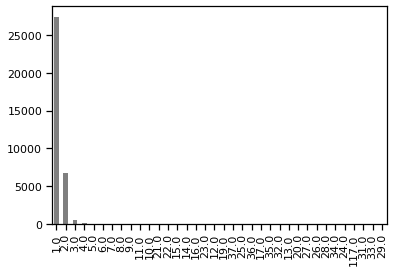

In [ ]:
#counting the number of transactions per individual
data['trans_count'].value_counts().plot(kind='bar', color= '#7f7f7f');

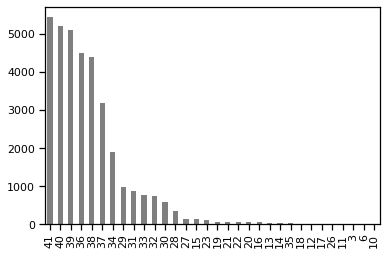

In [ ]:
#plotting distribution of payment method
data['payment_method_id'].value_counts().plot(kind='bar', color= '#7f7f7f');

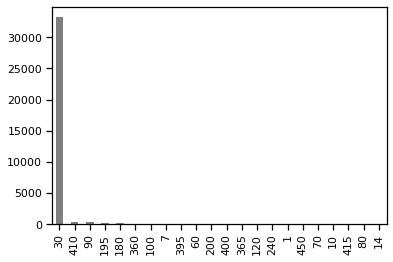

In [ ]:
#distribution of payment plan days
data['payment_plan_days'].value_counts().plot(kind='bar', color= '#7f7f7f');

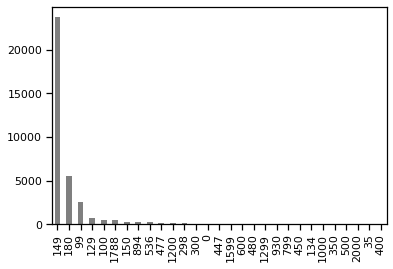

In [ ]:
# plotting the distribution of plan list price
data['plan_list_price'].value_counts().plot(kind='bar', color= '#7f7f7f');

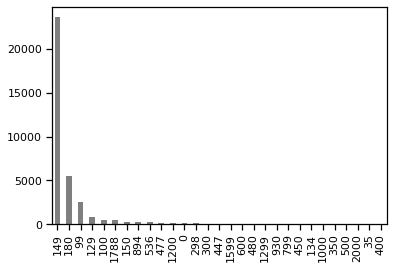

In [ ]:
# plotting the actual amount paid
data['actual_amount_paid'].value_counts().plot(kind='bar', color= '#7f7f7f');

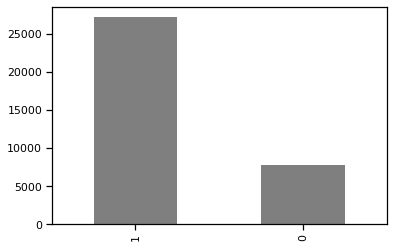

In [ ]:
# plotting distribution of automatically renewed subscription
data['is_auto_renew'].value_counts().plot(kind='bar', color= '#7f7f7f');

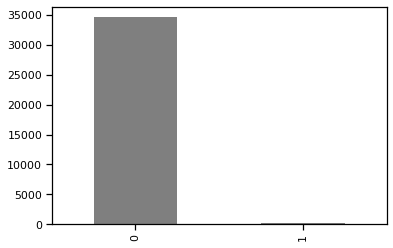

In [ ]:
# plotting the distribution of cancelled payments
data['is_cancel'].value_counts().plot(kind='bar', color= '#7f7f7f');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


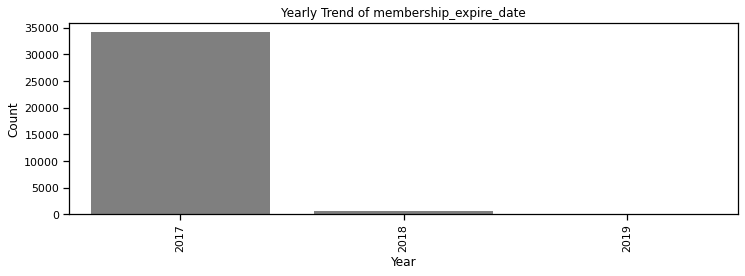

Yearly Count [(2017, 34242), (2018, 652), (2019, 2)]


In [ ]:
# plotting the yearly membership expire date
data['membership_expire_date_year'] = pd.DatetimeIndex(data['membership_expire_date']).year
data['membership_expire_date_year'] = data.membership_expire_date_year.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
year_count=data['membership_expire_date_year'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
year_order = data['membership_expire_date_year'].unique()
year_order = sorted(year_order, key=lambda x: str(x))
year_order = sorted(year_order, key=lambda x: float(x))
sns.barplot(year_count.index, year_count.values,order=year_order, color= '#7f7f7f')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Yearly Trend of membership_expire_date", fontsize=12)
plt.show()
year_count_2 = Counter(data['membership_expire_date_year']).most_common()
print("Yearly Count " +str(year_count_2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


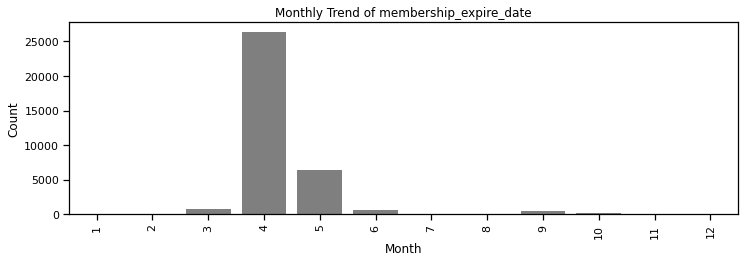

Monthly Count [(4, 26427), (5, 6339), (3, 823), (6, 597), (9, 426), (10, 145), (7, 66), (8, 33), (11, 18), (2, 12), (1, 5), (12, 5)]


In [ ]:
# plotting the monthly membership expire date
data['membership_expire_date_month'] = pd.DatetimeIndex(data['membership_expire_date']).month
data['membership_expire_date_month'] = data.membership_expire_date_month.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
month_count=data['membership_expire_date_month'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
month_order = data['membership_expire_date_month'].unique()
month_order = sorted(month_order, key=lambda x: str(x))
month_order = sorted(month_order, key=lambda x: float(x))
sns.barplot(month_count.index, month_count.values,order=month_order, color= '#7f7f7f')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monthly Trend of membership_expire_date", fontsize=12)
plt.show()
month_count_2 = Counter(data['membership_expire_date_month']).most_common()
print("Monthly Count " +str(month_count_2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


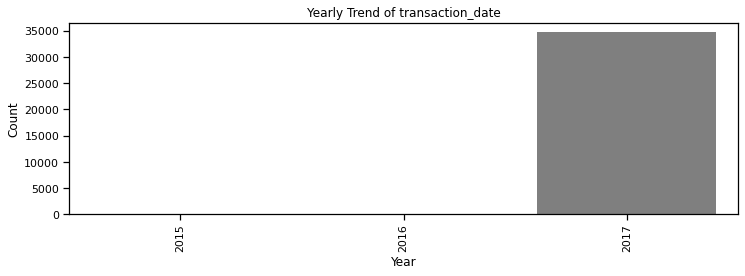

Yearly Count [(2017, 34807), (2016, 84), (2015, 5)]


In [ ]:
# plotting the latest transactions of each user by year
data['transaction_date_year'] = pd.DatetimeIndex(data['transaction_date']).year
data['transaction_date_year'] = data.transaction_date_year.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
year_count=data['transaction_date_year'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
year_order = data['transaction_date_year'].unique()
year_order = sorted(year_order, key=lambda x: str(x))
year_order = sorted(year_order, key=lambda x: float(x))
sns.barplot(year_count.index, year_count.values,order=year_order, color= '#7f7f7f')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Yearly Trend of transaction_date", fontsize=12)
plt.show()
year_count_2 = Counter(data['transaction_date_year']).most_common()
print("Yearly Count " +str(year_count_2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


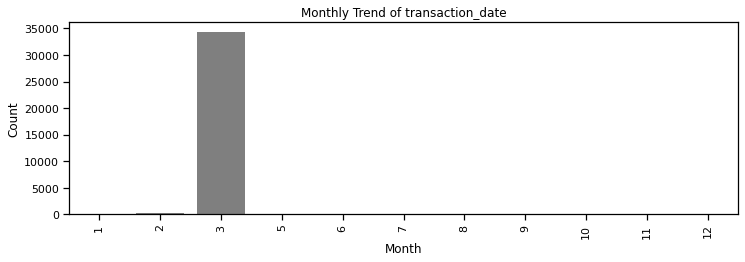

Monthly Count [(3, 34409), (2, 317), (1, 86), (12, 51), (11, 11), (10, 8), (9, 5), (7, 4), (8, 3), (6, 1), (5, 1)]


In [ ]:
# plotting the latest transactions of each user by month
data['transaction_date_month'] = pd.DatetimeIndex(data['transaction_date']).month
data['transaction_date_month'] = data.transaction_date_month.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
month_count=data['transaction_date_month'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
month_order = data['transaction_date_month'].unique()
month_order = sorted(month_order, key=lambda x: str(x))
month_order = sorted(month_order, key=lambda x: float(x))
sns.barplot(month_count.index, month_count.values,order=month_order, color= '#7f7f7f')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monthly Trend of transaction_date", fontsize=12)
plt.show()
month_count_2 = Counter(data['transaction_date_month']).most_common()
print("Monthly Count " +str(month_count_2))

In [ ]:
# dropping all of the newly created columns
data = data.drop(['transaction_date_year', 'transaction_date_month', 'transaction_date', 'membership_expire_date_year', 'membership_expire_date_month', 'membership_expire_date'], axis = 1)

In [ ]:
data

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,gender,registered_via,registration_init_time
0,1,1.0,38,410,1788,1788,0,0,78,20,30,16,1023,758,290831.795,9,28,female,3,2014-02-02
1,1,1.0,38,30,149,149,0,0,195,52,32,27,755,954,196523.899,4,17,female,3,2014-08-12
2,1,1.0,40,30,149,149,1,0,349,76,46,30,739,1101,191605.192,13,24,female,3,2014-09-20
3,1,2.0,32,360,1200,1200,0,0,1085,258,137,153,907,2032,303608.133,15,19,male,3,2014-11-12
4,1,1.0,38,30,149,149,0,0,595,120,79,99,1227,1574,335510.741,22,19,male,9,2015-05-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60639,0,1.0,37,30,149,149,1,0,91,34,28,32,1795,1626,439354.475,5,37,male,9,2011-07-02
60640,0,2.0,39,30,149,149,1,0,70,18,9,8,967,944,243090.571,13,33,female,9,2011-07-21
60642,0,1.0,40,30,149,149,1,0,157,44,45,35,1513,1355,419195.794,4,28,male,9,2011-08-12
60643,0,1.0,38,30,149,149,0,0,331,160,154,160,1239,866,355162.288,5,21,male,9,2011-08-19


User Logs

In [ ]:
data.describe()

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,registered_via
count,34896.000000,34896.00000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,3.489600e+04,34896.000000,34896.000000,34896.000000
mean,0.090268,1.29459,37.011348,39.854482,188.330124,188.068833,0.778313,0.008425,292.593449,71.929247,47.496733,57.693289,1697.205095,1462.644372,4.353704e+05,10.756734,27.545478,6.815566
std,0.286570,1.31692,4.242835,52.740743,217.179492,217.303597,0.415388,0.091402,296.728339,67.211151,39.058831,76.521529,1556.017364,963.833541,3.447857e+05,5.925554,25.367012,2.571065
min,0.000000,1.00000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,31.000000,2.589740e+04,1.000000,-2828.000000,3.000000
25%,0.000000,1.00000,36.000000,30.000000,149.000000,149.000000,1.000000,0.000000,117.000000,32.000000,23.000000,25.000000,802.000000,830.000000,2.210467e+05,5.000000,22.000000,4.000000
50%,0.000000,1.00000,38.000000,30.000000,149.000000,149.000000,1.000000,0.000000,216.000000,55.000000,38.000000,42.000000,1200.000000,1199.500000,3.231129e+05,13.000000,26.000000,9.000000
75%,0.000000,1.00000,40.000000,30.000000,149.000000,149.000000,1.000000,0.000000,374.000000,91.000000,61.000000,69.000000,1966.250000,1798.250000,5.148904e+05,14.000000,31.000000,9.000000
max,1.000000,117.00000,41.000000,450.000000,2000.000000,2000.000000,1.000000,1.000000,9315.000000,2129.000000,843.000000,4619.000000,30935.000000,17001.000000,7.746371e+06,22.000000,1037.000000,13.000000


In [ ]:
# creating logs dataset for investigation
logs = data[['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']]
logs.describe()

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,34896.000000,3.489600e+04
mean,292.593449,71.929247,47.496733,57.693289,1697.205095,1462.644372,4.353704e+05
std,296.728339,67.211151,39.058831,76.521529,1556.017364,963.833541,3.447857e+05
min,0.000000,0.000000,0.000000,0.000000,46.000000,31.000000,2.589740e+04
25%,117.000000,32.000000,23.000000,25.000000,802.000000,830.000000,2.210467e+05
50%,216.000000,55.000000,38.000000,42.000000,1200.000000,1199.500000,3.231129e+05
75%,374.000000,91.000000,61.000000,69.000000,1966.250000,1798.250000,5.148904e+05
max,9315.000000,2129.000000,843.000000,4619.000000,30935.000000,17001.000000,7.746371e+06


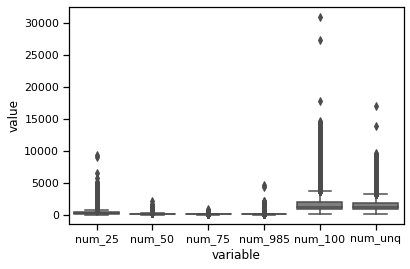

In [ ]:
# boxplots and outliers of the columns
percentage = pd.DataFrame(data = data, columns = ['num_25','num_50','num_75','num_985', 'num_100', 'num_unq'])

sns.boxplot(x="variable", y="value", data=pd.melt(percentage), color= '#7f7f7f')

plt.show()

In [ ]:
# removing outliers
Q1 = data['num_25'].quantile(0.25)
Q3 = data['num_25'].quantile(0.75)
IQR = Q3 - Q1
data = data.loc[(data['num_25'] < (Q3 + 1.5 * IQR))]

In [ ]:
Q1 = data['num_50'].quantile(0.25)
Q3 = data['num_50'].quantile(0.75)
IQR = Q3 - Q1
data = data.loc[(data['num_50'] < (Q3 + 1.5 * IQR))]

In [ ]:
Q1 = data['num_75'].quantile(0.25)
Q3 = data['num_75'].quantile(0.75)
IQR = Q3 - Q1
data = data.loc[(data['num_75'] < (Q3 + 1.5 * IQR))]

In [ ]:
Q1 = data['num_985'].quantile(0.25)
Q3 = data['num_985'].quantile(0.75)
IQR = Q3 - Q1
data = data.loc[(data['num_985'] < (Q3 + 1.5 * IQR))]

In [ ]:
Q1 = data['num_100'].quantile(0.25)
Q3 = data['num_100'].quantile(0.75)
IQR = Q3 - Q1
data = data.loc[(data['num_100'] < (Q3 + 1.5 * IQR))]

In [ ]:
Q1 = data['num_unq'].quantile(0.25)
Q3 = data['num_unq'].quantile(0.75)
IQR = Q3 - Q1
data = data.loc[(data['num_unq'] < (Q3 + 1.5 * IQR))]

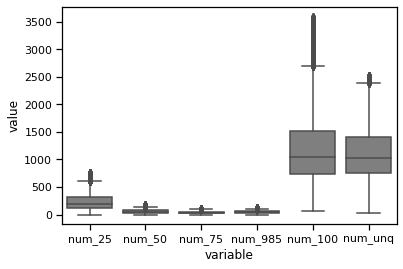

In [ ]:
# boxplot after removing of outliers
percentage = pd.DataFrame(data = data, columns = ['num_25','num_50','num_75','num_985', 'num_100', 'num_unq'])

sns.boxplot(x="variable", y="value", data=pd.melt(percentage), color= '#7f7f7f')

plt.show()

In [ ]:
data.describe()

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,registered_via
count,25440.000000,25440.000000,25440.000000,25440.000000,25440.000000,25440.000000,25440.000000,25440.000000,25440.000000,25440.000000,25440.000000,25440.000000,25440.000000,25440.000000,2.544000e+04,25440.000000,25440.000000,25440.000000
mean,0.090566,1.293986,37.096423,39.970951,188.287461,188.075000,0.784159,0.008137,230.886989,55.871619,37.826730,41.127516,1207.140881,1108.406211,3.170315e+05,10.734788,27.525197,6.793200
std,0.286997,1.363872,4.193652,52.928869,216.963671,217.063908,0.411413,0.089838,152.521419,33.237887,20.918299,23.921662,645.048653,491.198618,1.627256e+05,5.928839,28.284510,2.562594
min,0.000000,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000,31.000000,2.589740e+04,1.000000,-2828.000000,3.000000
25%,0.000000,1.000000,36.000000,30.000000,149.000000,149.000000,1.000000,0.000000,115.000000,31.000000,22.000000,23.000000,738.000000,747.000000,2.001416e+05,5.000000,22.000000,4.000000
50%,0.000000,1.000000,38.000000,30.000000,149.000000,149.000000,1.000000,0.000000,197.000000,50.000000,35.000000,37.000000,1048.000000,1034.000000,2.780559e+05,13.000000,26.000000,7.000000
75%,0.000000,1.000000,40.000000,30.000000,149.000000,149.000000,1.000000,0.000000,311.250000,76.000000,51.000000,56.000000,1520.250000,1405.000000,3.959841e+05,14.000000,31.000000,9.000000
max,1.000000,117.000000,41.000000,450.000000,2000.000000,2000.000000,1.000000,1.000000,759.000000,165.000000,101.000000,112.000000,3592.000000,2520.000000,2.539815e+06,22.000000,1032.000000,13.000000


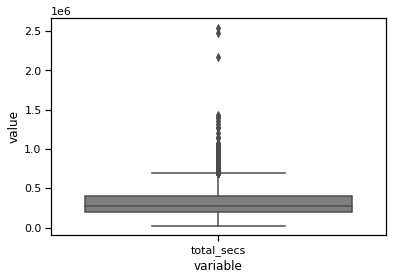

In [ ]:
# plotting outliers in total_secs column
percentage = pd.DataFrame(data = data, columns = ['total_secs'])

sns.boxplot(x="variable", y="value", data=pd.melt(percentage), color= '#7f7f7f')

plt.show()

In [ ]:
# removing outliers
Q1 = data['total_secs'].quantile(0.25)
Q3 = data['total_secs'].quantile(0.75)
IQR = Q3 - Q1
data = data.loc[(data['total_secs'] < (Q3 + 1.5 * IQR))]

In [ ]:
data.describe()

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,registered_via
count,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000
mean,0.091154,1.295098,37.103419,40.055417,188.571819,188.359684,0.782323,0.008068,232.981786,56.122693,37.911332,41.233242,1140.878408,1085.345748,299601.455999,10.733833,27.451449,6.782405
std,0.287833,1.385024,4.186579,53.109791,217.640024,217.740116,0.412675,0.089462,152.914399,33.247369,20.862621,23.896838,549.887134,470.380789,135053.124953,5.931109,28.732722,2.564776
min,0.000000,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000,31.000000,25897.401000,1.000000,-2828.000000,3.000000
25%,0.000000,1.000000,36.000000,30.000000,149.000000,149.000000,1.000000,0.000000,117.000000,31.000000,22.000000,23.000000,727.000000,740.000000,197335.942000,5.000000,22.000000,3.000000
50%,0.000000,1.000000,38.000000,30.000000,149.000000,149.000000,1.000000,0.000000,199.000000,50.000000,35.000000,37.000000,1022.000000,1019.000000,272281.638000,13.000000,26.000000,7.000000
75%,0.000000,1.000000,40.000000,30.000000,149.000000,149.000000,1.000000,0.000000,314.000000,76.000000,51.000000,56.000000,1454.000000,1369.000000,379850.886000,14.000000,31.000000,9.000000
max,1.000000,117.000000,41.000000,450.000000,2000.000000,2000.000000,1.000000,1.000000,759.000000,165.000000,101.000000,112.000000,3460.000000,2520.000000,689650.171000,22.000000,1032.000000,13.000000


Members

In [ ]:
data

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,gender,registered_via,registration_init_time
0,1,1.0,38,410,1788,1788,0,0,78,20,30,16,1023,758,290831.795,9,28,female,3,2014-02-02
1,1,1.0,38,30,149,149,0,0,195,52,32,27,755,954,196523.899,4,17,female,3,2014-08-12
2,1,1.0,40,30,149,149,1,0,349,76,46,30,739,1101,191605.192,13,24,female,3,2014-09-20
4,1,1.0,38,30,149,149,0,0,595,120,79,99,1227,1574,335510.741,22,19,male,9,2015-05-02
5,1,1.0,32,410,1788,1788,0,0,74,25,19,15,489,558,131712.715,6,30,female,3,2015-07-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60638,0,1.0,40,30,149,149,1,0,341,58,49,90,1609,1570,421777.968,4,22,female,7,2011-06-24
60639,0,1.0,37,30,149,149,1,0,91,34,28,32,1795,1626,439354.475,5,37,male,9,2011-07-02
60640,0,2.0,39,30,149,149,1,0,70,18,9,8,967,944,243090.571,13,33,female,9,2011-07-21
60642,0,1.0,40,30,149,149,1,0,157,44,45,35,1513,1355,419195.794,4,28,male,9,2011-08-12


In [ ]:
# summary statistics regarding members information
members = data[['city', 'bd', 'registered_via', 'gender', 'registration_init_time']]
members.describe()

,city,bd,registered_via
count,24541.000000,24541.000000,24541.000000
mean,10.733833,27.451449,6.782405
std,5.931109,28.732722,2.564776
min,1.000000,-2828.000000,3.000000
25%,5.000000,22.000000,3.000000
50%,13.000000,26.000000,7.000000
75%,14.000000,31.000000,9.000000
max,22.000000,1032.000000,13.000000


In [ ]:
data.describe()

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,registered_via
count,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000,24541.000000
mean,0.091154,1.295098,37.103419,40.055417,188.571819,188.359684,0.782323,0.008068,232.981786,56.122693,37.911332,41.233242,1140.878408,1085.345748,299601.455999,10.733833,27.451449,6.782405
std,0.287833,1.385024,4.186579,53.109791,217.640024,217.740116,0.412675,0.089462,152.914399,33.247369,20.862621,23.896838,549.887134,470.380789,135053.124953,5.931109,28.732722,2.564776
min,0.000000,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000,31.000000,25897.401000,1.000000,-2828.000000,3.000000
25%,0.000000,1.000000,36.000000,30.000000,149.000000,149.000000,1.000000,0.000000,117.000000,31.000000,22.000000,23.000000,727.000000,740.000000,197335.942000,5.000000,22.000000,3.000000
50%,0.000000,1.000000,38.000000,30.000000,149.000000,149.000000,1.000000,0.000000,199.000000,50.000000,35.000000,37.000000,1022.000000,1019.000000,272281.638000,13.000000,26.000000,7.000000
75%,0.000000,1.000000,40.000000,30.000000,149.000000,149.000000,1.000000,0.000000,314.000000,76.000000,51.000000,56.000000,1454.000000,1369.000000,379850.886000,14.000000,31.000000,9.000000
max,1.000000,117.000000,41.000000,450.000000,2000.000000,2000.000000,1.000000,1.000000,759.000000,165.000000,101.000000,112.000000,3460.000000,2520.000000,689650.171000,22.000000,1032.000000,13.000000


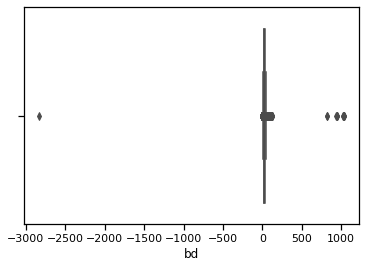

In [ ]:
#creating boxplot for birthday colum
sns.boxplot(x = data['bd'])

In [ ]:
# removing outliers in bd column
Q1 = data['bd'].quantile(0.25)
Q3 = data['bd'].quantile(0.75)
IQR = Q3 - Q1
data = data.loc[(data['bd'] > (Q1 - 1.5 * IQR)) & (data['bd'] < (Q3 + 1.5 * IQR))]

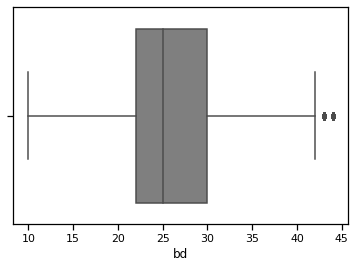

In [ ]:
# new boxplot
sns.boxplot(x = data['bd'], color= '#7f7f7f')

In [ ]:
data.describe()

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,registered_via
count,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000
mean,0.092165,1.287687,37.117846,40.183381,189.086839,188.879265,0.771665,0.008169,232.084356,56.032361,37.889827,41.158558,1138.849747,1084.103584,299032.885844,10.892896,26.251625,6.726485
std,0.289265,1.284111,4.121487,53.292048,217.471223,217.570145,0.419769,0.090017,152.703628,33.236516,20.828292,23.835519,550.122524,471.348551,135095.680051,5.889453,6.168184,2.587023
min,0.000000,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000,31.000000,25897.401000,1.000000,10.000000,3.000000
25%,0.000000,1.000000,36.000000,30.000000,149.000000,149.000000,1.000000,0.000000,117.000000,31.000000,22.000000,23.000000,726.000000,739.000000,196914.147250,5.000000,22.000000,3.000000
50%,0.000000,1.000000,38.000000,30.000000,149.000000,149.000000,1.000000,0.000000,198.000000,50.000000,35.000000,37.000000,1019.000000,1016.000000,271475.831500,13.000000,25.000000,7.000000
75%,0.000000,1.000000,40.000000,30.000000,149.000000,149.000000,1.000000,0.000000,312.000000,76.000000,51.000000,56.000000,1450.000000,1366.000000,378598.997750,14.000000,30.000000,9.000000
max,1.000000,117.000000,41.000000,450.000000,2000.000000,2000.000000,1.000000,1.000000,759.000000,165.000000,101.000000,112.000000,3460.000000,2520.000000,689650.171000,22.000000,44.000000,13.000000


In [ ]:
# counting the distribution of the age of users
bd_counts = data['bd'].value_counts()
bd_counts

24    1553
22    1531
26    1514
25    1510
27    1497
23    1444
21    1399
20    1288
28    1238
29     993
19     923
30     869
18     817
31     675
32     581
17     554
33     537
34     439
35     385
36     341
37     333
38     275
39     233
16     228
40     208
41     191
43     190
42     186
44     162
15      55
14       6
10       1
Name: bd, dtype: int64

In [ ]:
# plotting distribution of age
fig = px.bar(bd_counts, title = 'Age of Users')
fig.update_layout(
    xaxis_title = 'Age',
    yaxis_title = 'Frequency',
    title_x = 0,
    plot_bgcolor = "#FFFFFF",
    showlegend = False
)
fig.update_traces(marker_color='#7f7f7f')

In [ ]:
data.describe()

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,registered_via
count,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000
mean,0.092165,1.287687,37.117846,40.183381,189.086839,188.879265,0.771665,0.008169,232.084356,56.032361,37.889827,41.158558,1138.849747,1084.103584,299032.885844,10.892896,26.251625,6.726485
std,0.289265,1.284111,4.121487,53.292048,217.471223,217.570145,0.419769,0.090017,152.703628,33.236516,20.828292,23.835519,550.122524,471.348551,135095.680051,5.889453,6.168184,2.587023
min,0.000000,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000,31.000000,25897.401000,1.000000,10.000000,3.000000
25%,0.000000,1.000000,36.000000,30.000000,149.000000,149.000000,1.000000,0.000000,117.000000,31.000000,22.000000,23.000000,726.000000,739.000000,196914.147250,5.000000,22.000000,3.000000
50%,0.000000,1.000000,38.000000,30.000000,149.000000,149.000000,1.000000,0.000000,198.000000,50.000000,35.000000,37.000000,1019.000000,1016.000000,271475.831500,13.000000,25.000000,7.000000
75%,0.000000,1.000000,40.000000,30.000000,149.000000,149.000000,1.000000,0.000000,312.000000,76.000000,51.000000,56.000000,1450.000000,1366.000000,378598.997750,14.000000,30.000000,9.000000
max,1.000000,117.000000,41.000000,450.000000,2000.000000,2000.000000,1.000000,1.000000,759.000000,165.000000,101.000000,112.000000,3460.000000,2520.000000,689650.171000,22.000000,44.000000,13.000000


In [ ]:
# counting the distribution of gender
data['gender'].value_counts()

male      11817
female    10339
Name: gender, dtype: int64

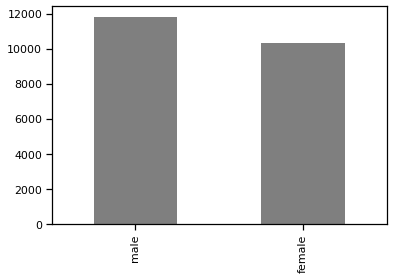

In [ ]:
# plotting the distribution of gender
data['gender'].value_counts().plot(kind='bar', color= '#7f7f7f');

In [ ]:
data.describe()

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,registered_via
count,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000,22156.000000
mean,0.092165,1.287687,37.117846,40.183381,189.086839,188.879265,0.771665,0.008169,232.084356,56.032361,37.889827,41.158558,1138.849747,1084.103584,299032.885844,10.892896,26.251625,6.726485
std,0.289265,1.284111,4.121487,53.292048,217.471223,217.570145,0.419769,0.090017,152.703628,33.236516,20.828292,23.835519,550.122524,471.348551,135095.680051,5.889453,6.168184,2.587023
min,0.000000,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000,31.000000,25897.401000,1.000000,10.000000,3.000000
25%,0.000000,1.000000,36.000000,30.000000,149.000000,149.000000,1.000000,0.000000,117.000000,31.000000,22.000000,23.000000,726.000000,739.000000,196914.147250,5.000000,22.000000,3.000000
50%,0.000000,1.000000,38.000000,30.000000,149.000000,149.000000,1.000000,0.000000,198.000000,50.000000,35.000000,37.000000,1019.000000,1016.000000,271475.831500,13.000000,25.000000,7.000000
75%,0.000000,1.000000,40.000000,30.000000,149.000000,149.000000,1.000000,0.000000,312.000000,76.000000,51.000000,56.000000,1450.000000,1366.000000,378598.997750,14.000000,30.000000,9.000000
max,1.000000,117.000000,41.000000,450.000000,2000.000000,2000.000000,1.000000,1.000000,759.000000,165.000000,101.000000,112.000000,3460.000000,2520.000000,689650.171000,22.000000,44.000000,13.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22156 entries, 0 to 60642
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   is_churn                22156 non-null  int64         
 1   trans_count             22156 non-null  float64       
 2   payment_method_id       22156 non-null  int64         
 3   payment_plan_days       22156 non-null  int64         
 4   plan_list_price         22156 non-null  int64         
 5   actual_amount_paid      22156 non-null  int64         
 6   is_auto_renew           22156 non-null  int64         
 7   is_cancel               22156 non-null  int64         
 8   num_25                  22156 non-null  int64         
 9   num_50                  22156 non-null  int64         
 10  num_75                  22156 non-null  int64         
 11  num_985                 22156 non-null  int64         
 12  num_100                 22156 non-null  int64 

In [ ]:
data.head()

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,gender,registered_via,registration_init_time
0,1,1.0,38,410,1788,1788,0,0,78,20,30,16,1023,758,290831.795,9,28,female,3,2014-02-02
1,1,1.0,38,30,149,149,0,0,195,52,32,27,755,954,196523.899,4,17,female,3,2014-08-12
2,1,1.0,40,30,149,149,1,0,349,76,46,30,739,1101,191605.192,13,24,female,3,2014-09-20
4,1,1.0,38,30,149,149,0,0,595,120,79,99,1227,1574,335510.741,22,19,male,9,2015-05-02
5,1,1.0,32,410,1788,1788,0,0,74,25,19,15,489,558,131712.715,6,30,female,3,2015-07-11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misin

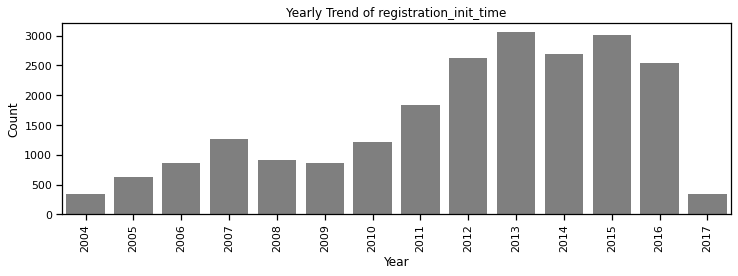

Yearly Count [(2013, 3064), (2015, 3010), (2014, 2685), (2012, 2616), (2016, 2536), (2011, 1828), (2007, 1273), (2010, 1210), (2008, 909), (2006, 861), (2009, 856), (2005, 620), (2017, 349), (2004, 339)]


In [ ]:
# plotting the distribution of membership registration by year
data['registration_init_time_year'] = pd.DatetimeIndex(data['registration_init_time']).year
data['registration_init_time_year'] = data.registration_init_time_year.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
year_count=data['registration_init_time_year'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
year_order = data['registration_init_time_year'].unique()
year_order = sorted(year_order, key=lambda x: str(x))
year_order = sorted(year_order, key=lambda x: float(x))
sns.barplot(year_count.index, year_count.values,order=year_order, color= '#7f7f7f')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Yearly Trend of registration_init_time", fontsize=12)
plt.show()
year_count_2 = Counter(data['registration_init_time_year']).most_common()
print("Yearly Count " +str(year_count_2))

In [ ]:
# dropping the column because of irrelevance
data = data.drop(['registration_init_time'], axis = 1)

Input Preparation

In [ ]:
data

,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,city,bd,gender,registered_via,registration_init_time_year
0,1,1.0,38,410,1788,1788,0,0,78,20,30,16,1023,758,290831.795,9,28,female,3,2014
1,1,1.0,38,30,149,149,0,0,195,52,32,27,755,954,196523.899,4,17,female,3,2014
2,1,1.0,40,30,149,149,1,0,349,76,46,30,739,1101,191605.192,13,24,female,3,2014
4,1,1.0,38,30,149,149,0,0,595,120,79,99,1227,1574,335510.741,22,19,male,9,2015
5,1,1.0,32,410,1788,1788,0,0,74,25,19,15,489,558,131712.715,6,30,female,3,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60634,0,1.0,40,30,149,149,1,0,156,49,32,45,1509,1541,392113.975,13,22,male,9,2011
60638,0,1.0,40,30,149,149,1,0,341,58,49,90,1609,1570,421777.968,4,22,female,7,2011
60639,0,1.0,37,30,149,149,1,0,91,34,28,32,1795,1626,439354.475,5,37,male,9,2011
60640,0,2.0,39,30,149,149,1,0,70,18,9,8,967,944,243090.571,13,33,female,9,2011


In [ ]:
# converting categorical columns into several columns
data = pd.get_dummies(data, columns=['gender', 'payment_method_id', 'registered_via', 'city'])

In [ ]:
data

,is_churn,trans_count,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,bd,registration_init_time_year,gender_female,gender_male,payment_method_id_6,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_40,payment_method_id_41,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,city_22
0,1,1.0,410,1788,1788,0,0,78,20,30,16,1023,758,290831.795,28,2014,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1.0,30,149,149,0,0,195,52,32,27,755,954,196523.899,17,2014,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1.0,30,149,149,1,0,349,76,46,30,739,1101,191605.192,24,2014,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,1.0,30,149,149,0,0,595,120,79,99,1227,1574,335510.741,19,2015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,1,1.0,410,1788,1788,0,0,74,25,19,15,489,558,131712.715,30,2015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60634,0,1.0,30,149,149,1,0,156,49,32,45,1509,1541,392113.975,22,2011,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
60638,0,1.0,30,149,149,1,0,341,58,49,90,1609,1570,421777.968,22,2011,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60639,0,1.0,30,149,149,1,0,91,34,28,32,1795,1626,439354.475,37,2011,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60640,0,2.0,30,149,149,1,0,70,18,9,8,967,944,243090.571,33,2011,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# defining X value
X = data.drop('is_churn', axis = 1)

In [ ]:
# defining target value
y = data['is_churn']

In [ ]:
# scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
X[['trans_count', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'bd', 'registration_init_time_year']] = scaler.fit_transform(X[['trans_count', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'bd', 'registration_init_time_year']])

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)

In [ ]:
# printing the shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16617, 74) (5539, 74) (16617,) (5539,)


In [ ]:
# checking imbalance
y_train.value_counts()

0    15069
1     1548
Name: is_churn, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
#over = SMOTE(sampling_strategy=0.50)
#under = RandomUnderSampler(sampling_strategy=0.3)

In [ ]:
#steps = [('o', over), ('u', under)]
#pipeline = Pipeline(steps=steps)

In [ ]:
# transform the dataset
#X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [ ]:
#smote = SMOTE()

In [ ]:
#X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# undersample dataset
#rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')
#X_train, y_train = rus.fit_resample(X_train, y_train)

In [ ]:
# oversample dataset
ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
X_train, y_train = ros.fit_resample(X_train, y_train)

In [ ]:
X_train['is_auto_renew'].value_counts()

1    15932
0    14206
Name: is_auto_renew, dtype: int64

In [ ]:
# making sure oversampled
print(X_train.shape, y_train.shape)

(30138, 74) (30138,)


In [ ]:
# making sure oversampled
print(X_test.shape, y_test.shape)

(5539, 74) (5539,)


In [ ]:
y_train.value_counts()

0    15069
1    15069
Name: is_churn, dtype: int64

In [ ]:
X_train

,trans_count,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,bd,registration_init_time_year,gender_female,gender_male,payment_method_id_6,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_40,payment_method_id_41,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,city_22
0,0.000000,0.064588,0.0900,0.0900,1,0,0.226614,0.448485,0.663366,0.508929,0.414584,0.559663,0.564163,0.558824,0.692308,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.000000,0.064588,0.0900,0.0900,0,0,0.171278,0.115152,0.099010,0.125000,0.551897,0.065890,0.667709,0.941176,0.769231,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.000000,0.064588,0.0745,0.0745,1,0,0.484848,0.575758,0.495050,0.464286,0.144369,0.296906,0.185179,0.441176,0.538462,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.000000,0.064588,0.0745,0.0745,1,0,0.218709,0.103030,0.237624,0.321429,0.226404,0.314986,0.319790,0.441176,0.923077,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0.000000,0.064588,0.0745,0.0745,1,0,0.291173,0.212121,0.257426,0.339286,0.294031,0.356770,0.366367,0.352941,0.692308,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,0.008621,0.013363,0.0000,0.0000,0,0,0.221344,0.315152,0.178218,0.312500,0.141723,0.239052,0.181550,0.441176,0.769231,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30134,0.008621,0.064588,0.0745,0.0745,1,0,0.071146,0.090909,0.217822,0.294643,0.203176,0.099638,0.240166,0.735294,0.692308,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30135,0.000000,0.064588,0.0745,0.0745,0,0,0.256917,0.381818,0.386139,0.294643,0.613643,0.874247,0.785377,0.411765,0.307692,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
30136,0.000000,0.398664,0.2680,0.2680,0,0,0.484848,0.303030,0.405941,0.383929,0.334019,0.420249,0.446400,0.882353,0.461538,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
X_train['is_cancel'].value_counts()

0    29564
1      574
Name: is_cancel, dtype: int64

In [ ]:
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.layers.core import Dropout
from keras import regularizers
from keras.models import Model, load_model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Activation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import time
from imblearn.over_sampling import RandomOverSampler 

In [ ]:
X_train

,trans_count,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,bd,registration_init_time_year,gender_female,gender_male,payment_method_id_6,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_40,payment_method_id_41,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,city_22
0,0.000000,0.064588,0.0900,0.0900,1,0,0.226614,0.448485,0.663366,0.508929,0.414584,0.559663,0.564163,0.558824,0.692308,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.000000,0.064588,0.0900,0.0900,0,0,0.171278,0.115152,0.099010,0.125000,0.551897,0.065890,0.667709,0.941176,0.769231,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.000000,0.064588,0.0745,0.0745,1,0,0.484848,0.575758,0.495050,0.464286,0.144369,0.296906,0.185179,0.441176,0.538462,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.000000,0.064588,0.0745,0.0745,1,0,0.218709,0.103030,0.237624,0.321429,0.226404,0.314986,0.319790,0.441176,0.923077,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0.000000,0.064588,0.0745,0.0745,1,0,0.291173,0.212121,0.257426,0.339286,0.294031,0.356770,0.366367,0.352941,0.692308,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30133,0.008621,0.013363,0.0000,0.0000,0,0,0.221344,0.315152,0.178218,0.312500,0.141723,0.239052,0.181550,0.441176,0.769231,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30134,0.008621,0.064588,0.0745,0.0745,1,0,0.071146,0.090909,0.217822,0.294643,0.203176,0.099638,0.240166,0.735294,0.692308,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30135,0.000000,0.064588,0.0745,0.0745,0,0,0.256917,0.381818,0.386139,0.294643,0.613643,0.874247,0.785377,0.411765,0.307692,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
30136,0.000000,0.398664,0.2680,0.2680,0,0,0.484848,0.303030,0.405941,0.383929,0.334019,0.420249,0.446400,0.882353,0.461538,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
y_test

51519    0
44317    0
16238    0
14902    0
53523    0
        ..
545      1
36371    1
52837    0
147      1
28155    0
Name: is_churn, Length: 5539, dtype: int64

In [ ]:
#getting the shape of X_train for the input layer
X_train.shape[1]

74

In [ ]:
#creating model
model = Sequential()
model.add(Dense(16, input_dim=74,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 16)                1200      
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 dense_61 (Dense)            (None, 8)                 136       
                                                                 
 dense_62 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience = 10)

In [ ]:
history = model.fit(x = X_train, y = y_train, epochs=100, batch_size=64, 
                    validation_data= [X_test, y_test], verbose=1, callbacks=[es])

Epoch 1/100
471/471 [==============================] - 1s 3ms/step - loss: 0.2516 - accuracy: 0.8795 - recall: 0.9133 - val_loss: 0.2763 - val_accuracy: 0.8332 - val_recall: 0.8462
Epoch 2/100
471/471 [==============================] - 1s 2ms/step - loss: 0.2513 - accuracy: 0.8766 - recall: 0.9088 - val_loss: 0.2500 - val_accuracy: 0.8702 - val_recall: 0.7874
Epoch 3/100
471/471 [==============================] - 1s 2ms/step - loss: 0.2495 - accuracy: 0.8778 - recall: 0.9045 - val_loss: 0.2613 - val_accuracy: 0.8657 - val_recall: 0.7915
Epoch 4/100
471/471 [==============================] - 1s 2ms/step - loss: 0.2488 - accuracy: 0.8806 - recall: 0.9021 - val_loss: 0.2950 - val_accuracy: 0.8287 - val_recall: 0.8603
Epoch 5/100
471/471 [==============================] - 1s 2ms/step - loss: 0.2510 - accuracy: 0.8781 - recall: 0.8993 - val_loss: 0.2686 - val_accuracy: 0.8550 - val_recall: 0.8117
Epoch 6/100
471/471 [==============================] - 1s 2ms/step - loss: 0.2483 - accuracy: 0

In [ ]:
# getting accuracy and loss score for the model
results = model.evaluate(X_test, y_test, batch_size=128)

44/44 [==============================] - 0s 2ms/step - loss: 0.2742 - accuracy: 0.8431 - recall: 0.8300


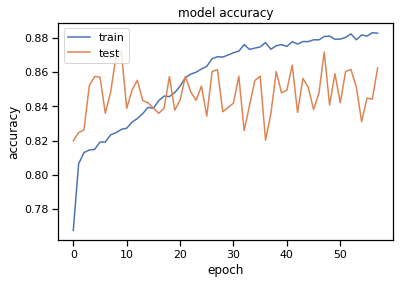

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification

In [ ]:
target_names = ['0', '1']

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(y_pred)

[[3.1109833e-12]
 [1.0925636e-01]
 [4.7038091e-05]
 ...
 [1.3300139e-01]
 [9.9985874e-01]
 [1.1426273e-01]]


In [ ]:
y_pred = np.matrix(y_pred)
print(y_pred)

[[3.1109833e-12]
 [1.0925636e-01]
 [4.7038091e-05]
 ...
 [1.3300139e-01]
 [9.9985874e-01]
 [1.1426273e-01]]


In [ ]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print(y_pred)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]


In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      5045
           1       0.34      0.83      0.49       494

    accuracy                           0.84      5539
   macro avg       0.66      0.84      0.70      5539
weighted avg       0.92      0.84      0.87      5539



In [ ]:
cm = confusion_matrix(y_test, y_pred)

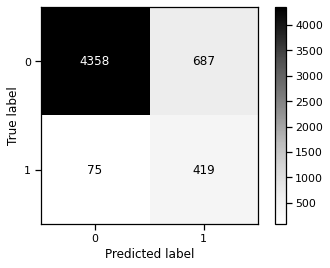

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Greys')

plt.show()

# **Finetuning**

In [ ]:
pip install keras-tuner --upgrade

In [ ]:
from keras_tuner import RandomSearch
import tensorflow 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner as kt
from tensorflow.keras import layers 
import keras_tuner as kt
from tensorflow.keras import layers 

In [ ]:
seed = 7
np.random.seed(seed)

Tuning of Number of Neurons

In [ ]:
# defining function to take in two different amount of neurons
def create_model(neuron1,neuron2):
  model = Sequential()
  model.add(Dense(neuron1, input_dim=74, activation='relu')),
  model.add(Dropout(0.2))
  model.add(Dense(neuron2, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
# using output as input into the model
model = KerasClassifier(build_fn=create_model, epochs = 500, batch_size = 128, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



In [ ]:
# trying lower and higher amount of neurons for each of the dense layers
neuron1 = [32,64,128]
neuron2 = [16,32,64]

In [ ]:
# creating a dictionary of the neurons
param_grids = dict(neuron1 = neuron1,neuron2 = neuron2)

In [ ]:
# making the grid use earlystopping with the val_loss
es = EarlyStopping(monitor = 'val_loss', patience = 10)

In [ ]:
# creating, fitting and evaluating the grid search
grid = GridSearchCV(estimator = model,
                    param_grid = param_grids,
                    verbose = 1,
                    scoring='accuracy',
                    cv=5)
grid_result = grid.fit(X_train,y_train,validation_data=(X_test, y_test),callbacks = [es])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/500
189/189 [==============================] - 1s 4ms/step - loss: 0.5064 - accuracy: 0.7439 - val_loss: 0.4587 - val_accuracy: 0.8177
Epoch 2/500
189/189 [==============================] - 1s 3ms/step - loss: 0.3809 - accuracy: 0.8179 - val_loss: 0.4190 - val_accuracy: 0.8319
Epoch 3/500
189/189 [==============================] - 0s 3ms/step - loss: 0.3393 - accuracy: 0.8434 - val_loss: 0.3336 - val_accuracy: 0.8581
Epoch 4/500
189/189 [==============================] - 1s 3ms/step - loss: 0.3108 - accuracy: 0.8553 - val_loss: 0.2877 - val_accuracy: 0.8745
Epoch 5/500
189/189 [==============================] - 1s 3ms/step - loss: 0.2945 - accuracy: 0.8652 - val_loss: 0.3388 - val_accuracy: 0.8559
Epoch 6/500
189/189 [==============================] - 1s 3ms/step - loss: 0.2796 - accuracy: 0.8715 - val_loss: 0.3160 - val_accuracy: 0.8585
Epoch 7/500
189/189 [==============================] - 1s 3ms/step - loss: 0.2655 

In [ ]:
64# best score of grid search
grid_result.best_score_

0.9145922589664801

In [ ]:
# getting best parameters
grid_result.best_params_

{'neuron1': 128, 'neuron2': 16}

In [ ]:
# trying lower and higher amount of neurons for each of the dense layers
neuron1 = [128,256,512]
neuron2 = [4,8,16]

In [ ]:
# creating a dictionary of the neurons
param_grids = dict(neuron1 = neuron1,neuron2 = neuron2)

In [ ]:
# creating, fitting and evaluating the grid search
grid = GridSearchCV(estimator = model,
                    param_grid = param_grids,
                    verbose = 1,
                    scoring='accuracy',
                    cv=5)
grid_result = grid.fit(X_train,y_train,validation_data=(X_test, y_test),callbacks = [es])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/500
189/189 [==============================] - 1s 5ms/step - loss: 0.4964 - accuracy: 0.7547 - val_loss: 0.6954 - val_accuracy: 0.8200
Epoch 2/500
189/189 [==============================] - 1s 3ms/step - loss: 0.4276 - accuracy: 0.8195 - val_loss: 0.6136 - val_accuracy: 0.8270
Epoch 3/500
189/189 [==============================] - 1s 3ms/step - loss: 0.3825 - accuracy: 0.8529 - val_loss: 0.5303 - val_accuracy: 0.8622
Epoch 4/500
189/189 [==============================] - 1s 3ms/step - loss: 0.3456 - accuracy: 0.8706 - val_loss: 0.5158 - val_accuracy: 0.8473
Epoch 5/500
189/189 [==============================] - 1s 3ms/step - loss: 0.3238 - accuracy: 0.8759 - val_loss: 0.4541 - val_accuracy: 0.8861
Epoch 6/500
189/189 [==============================] - 1s 3ms/step - loss: 0.3082 - accuracy: 0.8806 - val_loss: 0.4095 - val_accuracy: 0.8985
Epoch 7/500
189/189 [==============================] - 1s 3ms/step - loss: 0.2935 

In [ ]:
# finding the best score of the grid search
grid_result.best_score_

0.9175795295864473

In [ ]:
# getting the best parameters 
grid_result.best_params_

{'neuron1': 512, 'neuron2': 16}

In [ ]:
# trying lower amount of neurons for each of the dense layers
neuron1 = [512,1024.2024]
neuron2 = [16]

In [ ]:
# creating dictionary of newly created neuron values 
param_grids = dict(neuron1 = neuron1,neuron2 = neuron2)

In [ ]:
grid = GridSearchCV(estimator = model,
                    param_grid = param_grids,
                    verbose = 1,
                    scoring='accuracy',
                    cv=5)
grid_result = grid.fit(X_train,y_train,validation_data=(X_test, y_test),callbacks = [es])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Epoch 1/500
189/189 [==============================] - 2s 8ms/step - loss: 0.3834 - accuracy: 0.8209 - val_loss: 0.3653 - val_accuracy: 0.8455
Epoch 2/500
189/189 [==============================] - 1s 6ms/step - loss: 0.2773 - accuracy: 0.8757 - val_loss: 0.3148 - val_accuracy: 0.8785
Epoch 3/500
189/189 [==============================] - 1s 7ms/step - loss: 0.2424 - accuracy: 0.8920 - val_loss: 0.3395 - val_accuracy: 0.8545
Epoch 4/500
189/189 [==============================] - 1s 7ms/step - loss: 0.2241 - accuracy: 0.9001 - val_loss: 0.2750 - val_accuracy: 0.8913
Epoch 5/500
189/189 [==============================] - 1s 7ms/step - loss: 0.2121 - accuracy: 0.9080 - val_loss: 0.2447 - val_accuracy: 0.9081
Epoch 6/500
189/189 [==============================] - 1s 7ms/step - loss: 0.1999 - accuracy: 0.9139 - val_loss: 0.2892 - val_accuracy: 0.8872
Epoch 7/500
189/189 [==============================] - 1s 7ms/step - loss: 0.1902 

In [ ]:
grid_result.best_score_

0.9246130303481712

In [ ]:
grid_result.best_params_

{'neuron1': 512, 'neuron2': 16}

In [ ]:
# trying lower amount of neurons for each of the dense layers
neuron1 = [1024, 2048, 4096]
neuron2 = [512,1024,2048]

In [ ]:

# creating dictionary of newly created neuron values 
param_grids = dict(neuron1 = neuron1,neuron2 = neuron2)

In [ ]:
grid = GridSearchCV(estimator = model,
                    param_grid = param_grids,
                    verbose = 1,
                    scoring='accuracy',
                    cv=5)
grid_result = grid.fit(X_train,y_train,validation_data=(X_test, y_test),callbacks = [es])

In [ ]:
grid_result.best_score_

In [ ]:
grid_result.best_params_

Batch Size

In [ ]:
# using neurons of 1024 as input
#searching for batch size
def create_model():
  model = Sequential()
  model.add(Dense(512, input_dim=74, activation='relu')),
  model.add(Dropout(0.2))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs = 500, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



In [ ]:
batch_size = [64, 128, 256, 512, 1024]
param_grid = dict(batch_size=batch_size)

In [ ]:
param_grid = dict(batch_size=batch_size)

In [ ]:
grid = GridSearchCV(estimator = model,
                    param_grid = param_grid,
                    verbose = 1,
                    scoring='accuracy',
                    cv=5)
grid_result = grid.fit(X_train,y_train,validation_data=(X_test, y_test),callbacks = [es])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
grid_result.best_score_

0.9313498458441106

In [ ]:
grid_result.best_params_

{'batch_size': 64}

In [ ]:
# summarize history for accuracy
plt.plot(grid_result.grid_result['accuracy'])
plt.plot(grid_result.grid_result['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: ignored

NEW MODEL

In [ ]:
model = Sequential()
model.add(Dense(512, input_dim=74,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_279"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_837 (Dense)           (None, 512)               38400     
                                                                 
 dropout_279 (Dropout)       (None, 512)               0         
                                                                 
 dense_838 (Dense)           (None, 16)                8208      
                                                                 
 dense_839 (Dense)           (None, 1)                 17        
                                                                 
Total params: 46,625
Trainable params: 46,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x = X_train, y = y_train, epochs=500, batch_size=64, 
                    validation_data= [X_test, y_test], verbose=1, callbacks=[es])

Epoch 1/500
471/471 [==============================] - 3s 5ms/step - loss: 0.3444 - accuracy: 0.8413 - val_loss: 0.2625 - val_accuracy: 0.9011
Epoch 2/500
471/471 [==============================] - 2s 4ms/step - loss: 0.2582 - accuracy: 0.8863 - val_loss: 0.2640 - val_accuracy: 0.8967
Epoch 3/500
471/471 [==============================] - 2s 4ms/step - loss: 0.2301 - accuracy: 0.8992 - val_loss: 0.4696 - val_accuracy: 0.7761
Epoch 4/500
471/471 [==============================] - 2s 5ms/step - loss: 0.2170 - accuracy: 0.9079 - val_loss: 0.2837 - val_accuracy: 0.8886
Epoch 5/500
471/471 [==============================] - 2s 4ms/step - loss: 0.2049 - accuracy: 0.9130 - val_loss: 0.1913 - val_accuracy: 0.9336
Epoch 6/500
471/471 [==============================] - 2s 4ms/step - loss: 0.1940 - accuracy: 0.9183 - val_loss: 0.2044 - val_accuracy: 0.9256
Epoch 7/500
471/471 [==============================] - 2s 5ms/step - loss: 0.1828 - accuracy: 0.9243 - val_loss: 0.2069 - val_accuracy: 0.9267

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=64)

87/87 [==============================] - 0s 2ms/step - loss: 0.2140 - accuracy: 0.9260


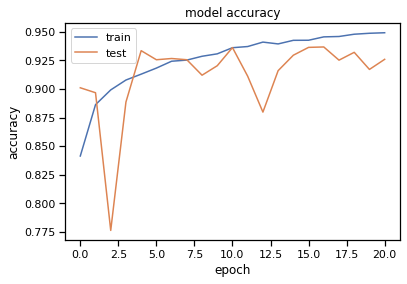

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

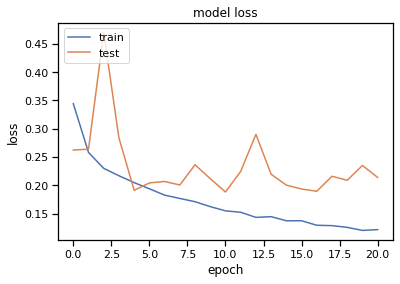

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dropout Layer

In [ ]:
def create_model(dropout_rate=0.0):
  model = Sequential()
  model.add(Dense(512, input_dim=74, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=500, batch_size=64, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



In [ ]:
dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
param_grid = dict(dropout_rate=dropout_rate)

In [ ]:
grid = GridSearchCV(estimator = model,
                    param_grid = param_grid,
                    verbose = 1,
                    scoring='accuracy',
                    cv=5)
grid_result = grid.fit(X_train,y_train,validation_data=(X_test, y_test),callbacks = [es])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
grid_result.best_score_

0.9317156020645427

In [ ]:
grid_result.best_params_

{'dropout_rate': 0.1}

Activation Function

In [ ]:
def create_model(activation1='relu', activation2='relu'):
  model = Sequential()
  model.add(Dense(512, input_dim=74, activation=activation2))
  model.add(Dropout(0.1))
  model.add(Dense(16, activation=activation2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=500, batch_size=64, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



In [ ]:
activation1 = ['softmax', 'relu', 'sigmoid']
activation2 = ['softmax', 'relu', 'sigmoid']
param_grid = dict(activation1=activation1,activation2=activation2)

In [ ]:
grid = GridSearchCV(estimator = model,
                    param_grid = param_grid,
                    verbose = 1,
                    scoring='accuracy',
                    cv=5)
grid_result = grid.fit(X_train,y_train,validation_data=(X_test, y_test),callbacks = [es])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
grid_result.best_score_

0.933473220320546

In [ ]:
grid_result.best_params_

{'activation1': 'sigmoid', 'activation2': 'relu'}

Evaluating Model

In [ ]:
model = Sequential()
model.add(Dense(512, input_dim=74,activation='sigmoid'))
model.add(Dropout(rate=0.1))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall'])
model.summary()

Model: "sequential_362"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1086 (Dense)          (None, 512)               38400     
                                                                 
 dropout_362 (Dropout)       (None, 512)               0         
                                                                 
 dense_1087 (Dense)          (None, 16)                8208      
                                                                 
 dense_1088 (Dense)          (None, 1)                 17        
                                                                 
Total params: 46,625
Trainable params: 46,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x = X_train, y = y_train, epochs=500, batch_size=64, 
                    validation_data= [X_test, y_test], verbose=1, callbacks=[es])

Epoch 1/500
471/471 [==============================] - 3s 5ms/step - loss: 0.4396 - recall: 0.7456 - val_loss: 0.3845 - val_recall: 0.7794
Epoch 2/500
471/471 [==============================] - 2s 4ms/step - loss: 0.3412 - recall: 0.8016 - val_loss: 0.2847 - val_recall: 0.7186
Epoch 3/500
471/471 [==============================] - 2s 4ms/step - loss: 0.3101 - recall: 0.8199 - val_loss: 0.2533 - val_recall: 0.6619
Epoch 4/500
471/471 [==============================] - 2s 4ms/step - loss: 0.2972 - recall: 0.8250 - val_loss: 0.1962 - val_recall: 0.5385
Epoch 5/500
471/471 [==============================] - 2s 4ms/step - loss: 0.2894 - recall: 0.8271 - val_loss: 0.2737 - val_recall: 0.7004
Epoch 6/500
471/471 [==============================] - 2s 4ms/step - loss: 0.2842 - recall: 0.8284 - val_loss: 0.2800 - val_recall: 0.7045
Epoch 7/500
471/471 [==============================] - 2s 4ms/step - loss: 0.2774 - recall: 0.8291 - val_loss: 0.3157 - val_recall: 0.7490
Epoch 8/500
471/471 [======

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=64)

87/87 [==============================] - 0s 2ms/step - loss: 0.2028 - recall: 0.5810


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: ignored

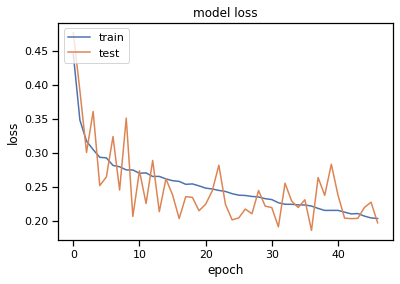

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(y_pred)

[[0.00307482]
 [0.01126981]
 [0.06712452]
 ...
 [0.05922905]
 [0.40113914]
 [0.08033246]]


In [ ]:
y_pred = np.matrix(y_pred)
print(y_pred)

[[0.00307482]
 [0.01126981]
 [0.06712452]
 ...
 [0.05922905]
 [0.40113914]
 [0.08033246]]


In [ ]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print(y_pred)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5045
           1       0.60      0.66      0.63       494

    accuracy                           0.93      5539
   macro avg       0.78      0.81      0.79      5539
weighted avg       0.93      0.93      0.93      5539



In [ ]:
#cm = confusion_matrix(y_test, y_pred)

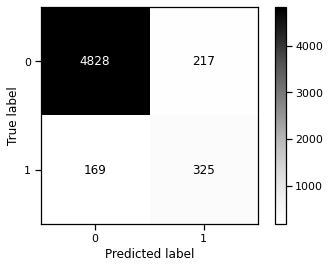

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Greys')

plt.show()

In [ ]:
y_pred = grid_result.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(accuracy_score(y_test, y_pred))

0.7793522267206477


In [ ]:
grid.best_score_ 

0.7606514148731044